# IMPORTS

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import tensorflow as tf
from transformers import ViTImageProcessor, ViTModel, ViTForImageClassification
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import label_binarize


/opt/homebrew/Caskroom/miniforge/base/envs/ComputerVision/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# LOADING DATA

In [2]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
categories = ["Normal","Osteopenia", "Osteoporosis"]

In [3]:
root_dir = 'Dataset/train'

In [4]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

In [5]:
class ViTWithHead(nn.Module):
    def __init__(self, pretrained_model, num_classes, dropout_rate=0.4):
        super(ViTWithHead, self).__init__()
        self.vit = pretrained_model  # Base ViT model
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(self.vit.config.hidden_size),  # Batch normalization
            nn.Dropout(dropout_rate),  # Dropout for regularization
            nn.Linear(self.vit.config.hidden_size, 256),  # Fully connected layer
            nn.ReLU(),  # ReLU activation
            nn.Dropout(0.3),  # Dropout for the second time
            nn.Linear(256, num_classes)  # Final classification layer
        )

    def forward(self, x):
        outputs = self.vit(x)  # Pass input through ViT model
        cls_token = outputs.last_hidden_state[:, 0]  # CLS token (first token)
        logits = self.classifier(cls_token)  # Pass CLS token through the classifier
        return logits

In [6]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = ViTWithHead(vit_model, num_classes=3)
model.to(device)

ViTWithHead(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, ou

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, processor, model, device):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor
        self.model = model
        self.device = device  # Store the device

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and preprocess the image
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        # Preprocess image (ensure pixel_values is correctly created)
        inputs = self.processor(images=image, return_tensors="np").to(self.device)  # Move inputs to device
        inputs = inputs.pixel_values  # Extract pixel_values

        return inputs, label

In [8]:
image_paths = []
labels = []
class_to_idx = {class_name: idx for idx, class_name in enumerate(os.listdir(root_dir))}

In [9]:
for class_name in os.listdir(root_dir):
    class_folder = os.path.join(root_dir, class_name)
    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_folder, img_name))
                labels.append(class_to_idx[class_name])

In [10]:
train_size = int(0.8 * len(image_paths))  # 80% for training
test_size = int(0.1 * len(image_paths))   # 10% for testing
val_size = len(image_paths) - train_size - test_size  # 10% for validation

train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, labels, train_size=train_size, stratify=labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, train_size=val_size, stratify=temp_labels)

In [11]:
train_dataset = CustomDataset(train_paths, train_labels, processor, model, device)
val_dataset = CustomDataset(val_paths, val_labels, processor, model, device)
test_dataset = CustomDataset(test_paths, test_labels, processor, model, device)

In [12]:
trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:
for features, labels in trainLoader:
    features, labels = features.to(device), labels.to(device)
    print(features.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 3, 224, 224])
torch.Size([32])


# TRAINING

In [14]:
if next(model.parameters()).is_mps:
    print("Model is running on MPS (GPU).")
else:
    print("Model is running on CPU.")

Model is running on MPS (GPU).


In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=250, early_stopping_patience=5):

    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Lists to store training history
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        for features, labels in train_loader:  # Use features instead of images
            features, labels = features.to(device), labels.to(device)  # Move to the correct device (GPU/CPU)
            optimizer.zero_grad()

            # The features shape is [batch_size, 1, 3, 224, 224]
            # Since ViT expects [batch_size, channels, height, width] shape,
            # we need to reshape or flatten the data to remove the extra dimension.

            # Reshape from [batch_size, 1, 3, 224, 224] to [batch_size, 3, 224, 224]
            features = features.squeeze(1)  # Remove the extra channel dimension

            # Forward pass (directly pass the features into the classifier)
            outputs = model(features)  # No need to pass through image processing

            # If the output is a tensor, we directly use it as logits
            logits = outputs  # Direct tensor output

            # Ensure labels are in the correct format (not one-hot encoded)
            if len(labels.shape) > 1:  # If labels are one-hot encoded
                labels = labels.argmax(dim=1)  # Convert to class indices

            # Compute the loss
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = logits.max(1)  # Get predicted class indices
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Validation Loop
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for features, labels in val_loader:  # Use features instead of images
                features, labels = features.to(device), labels.to(device)

                # Reshape features from [batch_size, 1, 3, 224, 224] to [batch_size, 3, 224, 224]
                features = features.squeeze(1)

                outputs = model(features)  # Pass features to the model
                logits = outputs  # Direct tensor output (no .logits attribute)

                # Ensure labels are in the correct format (not one-hot encoded)
                if len(labels.shape) > 1:
                    labels = labels.argmax(dim=1)

                # Compute the validation loss
                loss = criterion(logits, labels)
                val_loss += loss.item()

                _, predicted = logits.max(1)  # Get predicted class indices
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        # Compute epoch-wise losses and accuracies
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = correct_train / total_train
        val_acc = correct_val / total_val

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} - Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Update LR Scheduler
        scheduler.step(avg_val_loss)

        for param_group in optimizer.param_groups:
            print(f"Epoch [{epoch+1}/{num_epochs}] - LR: {param_group['lr']:.6f}")

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "Models/ViT/best_vit_model.pth")  # Save best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered. Training stopped.")
            break

    # Return Training History
    return train_losses, val_losses, train_accuracies, val_accuracies

In [17]:
for param in model.vit.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, trainLoader, validLoader, criterion, optimizer, scheduler, num_epochs=250, early_stopping_patience=8)

Epoch [1/250] - Train Loss: 0.8132, Train Acc: 0.6294 - Val Loss: 0.6755, Val Acc: 0.7047
Epoch [1/250] - LR: 0.001000
Epoch [2/250] - Train Loss: 0.6875, Train Acc: 0.6934 - Val Loss: 0.5981, Val Acc: 0.7214
Epoch [2/250] - LR: 0.001000
Epoch [3/250] - Train Loss: 0.6486, Train Acc: 0.7150 - Val Loss: 0.6139, Val Acc: 0.7326
Epoch [3/250] - LR: 0.001000
Epoch [4/250] - Train Loss: 0.6312, Train Acc: 0.7213 - Val Loss: 0.6005, Val Acc: 0.7354
Epoch [4/250] - LR: 0.001000
Epoch [5/250] - Train Loss: 0.5983, Train Acc: 0.7395 - Val Loss: 0.6128, Val Acc: 0.7103
Epoch [5/250] - LR: 0.001000
Epoch [6/250] - Train Loss: 0.5777, Train Acc: 0.7490 - Val Loss: 0.5483, Val Acc: 0.7437
Epoch [6/250] - LR: 0.001000
Epoch [7/250] - Train Loss: 0.5755, Train Acc: 0.7458 - Val Loss: 0.6114, Val Acc: 0.7465
Epoch [7/250] - LR: 0.001000
Epoch [8/250] - Train Loss: 0.5520, Train Acc: 0.7531 - Val Loss: 0.5836, Val Acc: 0.7604
Epoch [8/250] - LR: 0.001000
Epoch [9/250] - Train Loss: 0.5469, Train Acc: 0

# FINE-TUNING

In [17]:
model.load_state_dict(torch.load("Models/ViT/ViT-Base16-in21k.pth", map_location=device))

for param in model.vit.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-6)
train_losses_finetune, val_losses_finetune, train_accuracies_finetune, val_accuracies_finetune = train_model(
    model, trainLoader, validLoader, criterion, optimizer, scheduler, num_epochs=250, early_stopping_patience=8
)

Epoch [1/250] - Train Loss: 0.2731, Train Acc: 0.9035 - Val Loss: 0.1718, Val Acc: 0.9359
Epoch [1/250] - LR: 0.000001
Epoch [2/250] - Train Loss: 0.2500, Train Acc: 0.9091 - Val Loss: 0.1685, Val Acc: 0.9387
Epoch [2/250] - LR: 0.000001
Epoch [3/250] - Train Loss: 0.2437, Train Acc: 0.9094 - Val Loss: 0.1692, Val Acc: 0.9387
Epoch [3/250] - LR: 0.000001
Epoch [4/250] - Train Loss: 0.2262, Train Acc: 0.9136 - Val Loss: 0.1720, Val Acc: 0.9443
Epoch [4/250] - LR: 0.000001
Epoch [5/250] - Train Loss: 0.2220, Train Acc: 0.9206 - Val Loss: 0.1760, Val Acc: 0.9415
Epoch [5/250] - LR: 0.000001
Epoch [6/250] - Train Loss: 0.2279, Train Acc: 0.9220 - Val Loss: 0.1733, Val Acc: 0.9359
Epoch [6/250] - LR: 0.000001
Epoch [7/250] - Train Loss: 0.2105, Train Acc: 0.9189 - Val Loss: 0.1718, Val Acc: 0.9415
Epoch [7/250] - LR: 0.000001
Epoch [8/250] - Train Loss: 0.2041, Train Acc: 0.9252 - Val Loss: 0.1766, Val Acc: 0.9415
Epoch [8/250] - LR: 0.000001
Epoch [9/250] - Train Loss: 0.2038, Train Acc: 0

# PLOTS

In [18]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

## Pre-Trained

In [18]:
# plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

## Fine-Tuned

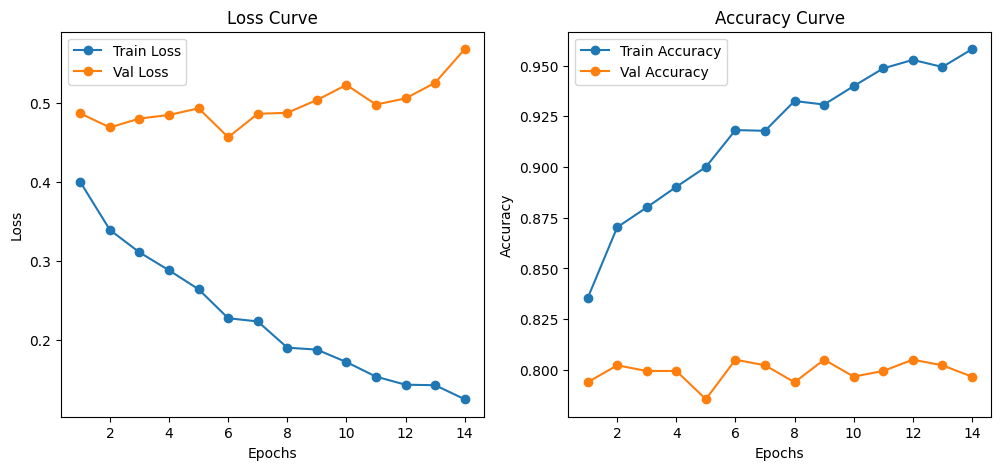

In [ ]:
plot_metrics(train_losses_finetune, val_losses_finetune, train_accuracies_finetune, val_accuracies_finetune)

# TESTING

In [15]:
model.load_state_dict(torch.load("Models/ViT/best_vit_model.pth", map_location=device))

<All keys matched successfully>

In [16]:
def evaluate_model(model, test_loader, categories):
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Remove extra dimension (num_views=1) -> (batch, channels, height, width)
            images = images.squeeze(1)  # Shape becomes [32, 3, 224, 224]

            print(f"Processed Input Shape: {images.shape}")  # Debugging step

            outputs = model(images)  # No .logits needed, as your model directly returns logits
            _, predicted = outputs.max(1)

            # If labels are one-hot encoded, convert them to class indices
            if len(labels.shape) > 1:
                labels = labels.argmax(dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print Classification Report
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=categories))

In [17]:
evaluate_model(model, testLoader, categories)

Processed Input Shape: torch.Size([32, 3, 224, 224])
Processed Input Shape: torch.Size([32, 3, 224, 224])
Processed Input Shape: torch.Size([32, 3, 224, 224])
Processed Input Shape: torch.Size([32, 3, 224, 224])
Processed Input Shape: torch.Size([32, 3, 224, 224])
Processed Input Shape: torch.Size([32, 3, 224, 224])
Processed Input Shape: torch.Size([32, 3, 224, 224])
Processed Input Shape: torch.Size([32, 3, 224, 224])
Processed Input Shape: torch.Size([32, 3, 224, 224])
Processed Input Shape: torch.Size([32, 3, 224, 224])
Processed Input Shape: torch.Size([32, 3, 224, 224])
Processed Input Shape: torch.Size([5, 3, 224, 224])
Classification Report:
               precision    recall  f1-score   support

      Normal       0.96      0.92      0.94       116
  Osteopenia       0.96      0.98      0.97       119
Osteoporosis       0.94      0.95      0.94       122

    accuracy                           0.95       357
   macro avg       0.95      0.95      0.95       357
weighted avg   

# PR CURVE

In [19]:
def find_best_thresholds(model, test_loader, num_classes):
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            # Convert labels to numpy
            labels = labels.cpu().numpy()

            # Ensure labels are correctly shaped
            if labels.ndim == 1:
                labels = labels.reshape(-1, 1)  # Shape [batch_size, 1]

            # Remove extra dimension (num_views=1) -> (batch, channels, height, width)
            images = images.squeeze(1)  # Shape becomes [batch, 3, 224, 224]

            # Get model output logits
            outputs = model(images)  # No `.logits` needed

            # Convert logits to probabilities
            probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Softmax for multi-class classification

            all_probs.append(probs)
            all_labels.append(labels)

    # Convert lists to numpy arrays
    all_probs = np.concatenate(all_probs, axis=0)  # Shape: [n_samples, n_classes]
    all_labels = np.concatenate(all_labels, axis=0)  # Shape: [n_samples, 1] (single-label format)

    # One-hot encode labels (needed for multi-class precision-recall curve)
    all_labels = label_binarize(all_labels, classes=np.arange(num_classes))  # Shape: [n_samples, n_classes]

    best_thresholds = []

    # Compute best threshold for each class
    for class_idx in range(num_classes):
        binary_labels = all_labels[:, class_idx]  # Get class labels (binary format)

        # Compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(binary_labels, all_probs[:, class_idx])

        # Compute F1 scores for each threshold
        f1_scores = (2 * precision * recall) / (precision + recall + np.finfo(float).eps)  # Avoid division by zero

        # Get threshold with max F1 score
        best_threshold = thresholds[np.argmax(f1_scores)] if thresholds.size > 0 else 0.5
        best_thresholds.append(best_threshold)

        print(f"Best threshold for class {class_idx}: {best_threshold:.4f}")

    return best_thresholds


best_thresholds = find_best_thresholds(model, testLoader, 3)
best_thresholds

Best threshold for class 0: 0.4861
Best threshold for class 1: 0.5007
Best threshold for class 2: 0.5129


[0.48613712, 0.50073874, 0.51286143]

In [20]:
def evaluate_with_best_thresholds(model, test_loader, best_thresholds, categories):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.cpu().numpy()

            # Ensure images are 4D (batch_size, num_channels, height, width)
            if len(images.shape) == 5:  # Check if images have an extra dimension
                images = images.squeeze(1)  # Remove the extra dimension, if necessary

            # Ensure labels are in a multi-label format (one-hot encoded)
            if labels.ndim == 1:  # If labels are single integers (multiclass)
                labels = np.eye(len(categories))[labels]  # Convert to one-hot

            outputs = model(images)
            if isinstance(outputs, tuple):  # Some models return a tuple
                outputs = outputs[0]

            # Apply sigmoid activation
            probs = torch.sigmoid(outputs).cpu().numpy()

            # Apply best thresholds for each class
            preds = (probs > np.array(best_thresholds)).astype(int)
            preds = np.argmax(preds*probs, axis=1)
            preds = label_binarize(preds, classes=np.arange(len(categories)))

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Ensure both are in the same shape and format
    if all_labels.shape != all_preds.shape:
        raise ValueError(f"Shape mismatch: labels {all_labels.shape}, preds {all_preds.shape}")

    # Print Classification Report
    print("Classification Report with Optimized Thresholds:\n",
          classification_report(all_labels, all_preds, target_names=categories))

In [21]:
# Evaluate with best thresholds
evaluate_with_best_thresholds(model, testLoader, best_thresholds, categories)

Classification Report with Optimized Thresholds:
               precision    recall  f1-score   support

      Normal       0.96      0.92      0.94       116
  Osteopenia       0.96      0.98      0.97       119
Osteoporosis       0.94      0.95      0.94       122

   micro avg       0.95      0.95      0.95       357
   macro avg       0.95      0.95      0.95       357
weighted avg       0.95      0.95      0.95       357
 samples avg       0.95      0.95      0.95       357



In [22]:
os.makedirs(os.path.dirname("Models/ViT/"), exist_ok=True)

In [23]:
torch.save(model.state_dict(), "Models/ViT/ViT-Base16-in21k.pth")